# CO₂ Flux Calculations

## CO₂ chamber data from different measurement sites, each in a separate Excel sheet.    
  
#### Manual Data preparation and cleaning:
In order not to omit any measuring periods, gaps in the CO₂ measurement were filled with neighbouring CO₂ data,   
as were missing temperature data, which were supplemented with neighbouring temperature data.
for the moment:  
only the three collums: time, CO₂ ppm, temperature DegC on the sheet  
->  other collumns are deleted   

#### Procedure: 

1. Automatically analyze each sheet,
2. Find the best linear trend (fit) in CO₂ concentration,
3. Use only the first 10 minutes (60 data points) of that linear segment to calculate:  
   - Start and end CO₂
   - CO₂ flux (based on chamber parameters),
4. Collect all results in a table,
5. Export:
   - A CSV summary table
   - A PDF report (plots)
   - Individual PNG plots
   - (Optional) a Word report

In [9]:
# 📦 Pakete laden (nur einmalig installieren, falls nötig)
# install.packages("readODS")
# install.packages("ggplot2")
# install.packages("gridExtra")
# install.packages("officer")
# install.packages("flextable")

# Load libraries 
library(readODS)
library(ggplot2)
library(gridExtra)
library(officer)
library(flextable)

#  Benutzerdefinierter Speicherpfad (hier anpassen)
output_path <- "C:/Users/sophia/Dropbox/MASTER/3_AnnKathrin/CO2_ChatGPT/Ergebnisse"

#  Quelldatei definieren
file_path <- "C:/Users/sophia/Dropbox/MASTER/3_AnnKathrin/CO2_ChatGPT/CO2_AK_final.ods"
sheets <- ods_sheets(file_path)

#  Ergebnis- und Plotliste vorbereiten
results <- data.frame()
plots_list <- list()

#  Parameter
min_window <- 50
step_size <- 5

#  Analyse für jedes Sheet
for (sheet in sheets) {
  df <- read_ods(file_path, sheet = sheet)[, 1:3]
  colnames(df) <- c("x", "y", "c")
  df <- na.omit(df)

# x: time steps (every 10 seconds)
# y: CO₂ concentration (ppm)
# c: temperature (°C)
    
# Skip sheets with too few data points    
  n <- nrow(df)
  if (n < min_window) {
    cat("⚠️  Sheet", sheet, "übersprungen (zu wenig Daten)\n")
    next
  }

  best_r2 <- -Inf
  best_start <- NA
  best_end <- NA

# Search for the best linear fit
# It tries various segment lengths (starting at 50 points), finds the one with the highest R².
    
  for (window_size in seq(min_window, n, by = 10)) {                          # alternative: min(60, n) anstelle von n  # n besseres R2 
    for (start in seq(1, n - window_size + 1, by = step_size)) {
      end <- start + window_size - 1
      x <- df$x[start:end]
      y <- df$y[start:end]

      model <- lm(y ~ x)
      r2 <- summary(model)$r.squared

      if (r2 > best_r2 || (r2 == best_r2 && (end - start) > (best_end - best_start))) {
        best_r2 <- r2
        best_start <- start
        best_end <- end
      }
    }
  }

  # Ergebnisdaten berechnen
  segment_data <- df[best_start:best_end, ]

  # 🔹 Nur die ersten 60 Punkte des besten Fits verwenden (max. 10 Minuten)
  if (nrow(segment_data) > 60) {
    segment_data <- segment_data[1:60, ]
  }

  x_start <- segment_data$x[1]
  x_end <- segment_data$x[nrow(segment_data)]
  y_start <- segment_data$y[1]
  y_end <- segment_data$y[nrow(segment_data)]
  count_x <- nrow(segment_data)
  minutes <- count_x / 6
  mean_c <- mean(segment_data$c)

  
# Calculate CO₂ Flux
# Using the formula from Boodoo et al. (2017), the script calculates CO₂ flux in mg C / m² / hour:
    
  DeltaCO2 <- y_end - y_start
  Vchamber <- 7
  RMM <- 12.011
  A <- pi * 0.28^2
  Time <- minutes / 60
  R <- 8.31446261815324
  Temp <- mean_c + 273.15
  Rho <- 1013.2
  Vm <- (R * Temp) / Rho
  CO2mol <- DeltaCO2 * 10^(-6) * Vchamber / Vm
  fCO2 <- CO2mol * RMM * 1000 / (A * Time)

  # Store all results in a summary table
  results <- rbind(results, data.frame(
    Sheet = sheet,
    X_Start = x_start,
    X_End = x_end,
    Y_Start = y_start,
    Y_End = y_end,
    Count_X = count_x,
    Minutes = round(minutes, 2),
    Mean_C = round(mean_c, 4),
    R2 = round(best_r2, 4),  #highest R²
    Flux = round(fCO2, 2)
  ))


  # Create plots
  # Plots the full CO₂ curve, highlights the 10-minute segment, and adds the linear fit:  
   
  model_segment <- lm(y ~ x, data = segment_data)
  segment_data$y_fit <- predict(model_segment, newdata = segment_data)

  p <- ggplot(df, aes(x = x, y = y)) +
    geom_point(alpha = 0.3, color = "gray") +
    geom_point(data = segment_data, aes(x = x, y = y), color = "black") +
    geom_line(data = segment_data, aes(x = x, y = y_fit), color = "forestgreen", linewidth = 1.2) +
    ggtitle(paste0("Sheet: ", sheet, " | R² = ", round(best_r2, 4))) +
    theme_minimal()

  plots_list[[sheet]] <- p
}



# Export results

# 📈 Save CSV summary
write.csv(results, file = file.path(output_path, "analyse_ergebnisse.csv"), row.names = FALSE)

# 📄 Create PDF report with table and plots
pdf(file = file.path(output_path, "analyse_ergebnisse.pdf"), width = 8.5, height = 11)

# Seite 1: Tabelle mit Rand
par(mar = c(3, 4, 4, 2))
plot.new()
text(0, 1, "Analyse-Ergebnisse (Tabelle):", adj = c(0, 1), cex = 1.2, font = 2)
text(0, 0.95, capture.output(print(results)), adj = c(0, 1), family = "mono", cex = 0.6)

# Weitere Seiten: Plots
for (p in plots_list) {
  print(p)
}

dev.off()

# 📋 Export each plot as PNG
for (sheet in names(plots_list)) {
  file_name <- paste0("plot_", sheet, ".png")
  ggsave(
    filename = file.path(output_path, file_name),
    plot = plots_list[[sheet]],
    width = 6, height = 4, dpi = 300
  )
}


# (Optional) Create Word file with table and plots

# doc <- read_docx()
# doc <- body_add_par(doc, "Analyse-Ergebnisse", style = "heading 1")
# ft <- flextable(results)
# doc <- body_add_flextable(doc, ft)
# for (sheet in names(plots_list)) {
#   img_path <- file.path(output_path, paste0("plot_", sheet, ".png"))
#   ggsave(img_path, plot = plots_list[[sheet]], width = 6, height = 4)
#   doc <- body_add_par(doc, sheet, style = "heading 2")
#   doc <- body_add_img(doc, src = img_path, width = 6, height = 4)
# }
# print(doc, target = file.path(output_path, "analyse_ergebnisse.docx"))


New names:
• `` -> `...4`
• `` -> `...5`
New names:
• `` -> `...4`
• `` -> `...5`
New names:
• `` -> `...4`
• `` -> `...5`
New names:
• `` -> `...4`
• `` -> `...5`
• `` -> `...6`
• `` -> `...7`
New names:
• `` -> `...4`
• `` -> `...5`
New names:
• `` -> `...4`
• `` -> `...5`
New names:
• `` -> `...4`
• `` -> `...5`
New names:
• `` -> `...4`
• `` -> `...5`
• `` -> `...6`
New names:
• `` -> `...4`
• `` -> `...5`
• `` -> `...6`
• `` -> `...7`
• `` -> `...8`
• `` -> `...9`
• `` -> `...10`
• `` -> `...11`


pdf 
  2

✅ In Summary:
- The script automatically processes each dataset,
 - Finds the best linear 10+ minute trend,
 - Uses the first 10 minutes of that trend,
 - Calculates CO₂ flux and saves the results.

#### 🖥️ showing the table


In [10]:
View(results)

Sheet,X_Start,X_End,Y_Start,Y_End,Count_X,Minutes,Mean_C,R2,Flux
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
S3_VM_gr,66,125,392,290,60,10.00,14.8477,0.9991,-88.40
S4_NM_gr,32,91,482,357,60,10.00,17.3023,0.9978,-107.41
S5_NM_gr,96,145,459,399,50,8.33,16.0384,0.9982,-62.14
S6_NM_gr,56,115,463,437,60,10.00,12.1632,0.9942,-22.74
S7_NM_gr,116,175,444,424,60,10.00,10.6707,0.9877,-17.59
S2_VM_bl,36,85,463,367,50,8.33,10.5890,0.9945,-101.33
S3_NM_bl,66,125,250,222,60,10.00,9.6797,0.9876,-24.71
letztesMal1_29_07_S4_gr,366,425,426,385,60,10.00,9.7952,0.9983,-36.17
letztesMal2_gr,251,310,421,343,60,10.00,8.8880,0.9971,-69.03


#### 🖥️ showing the plots

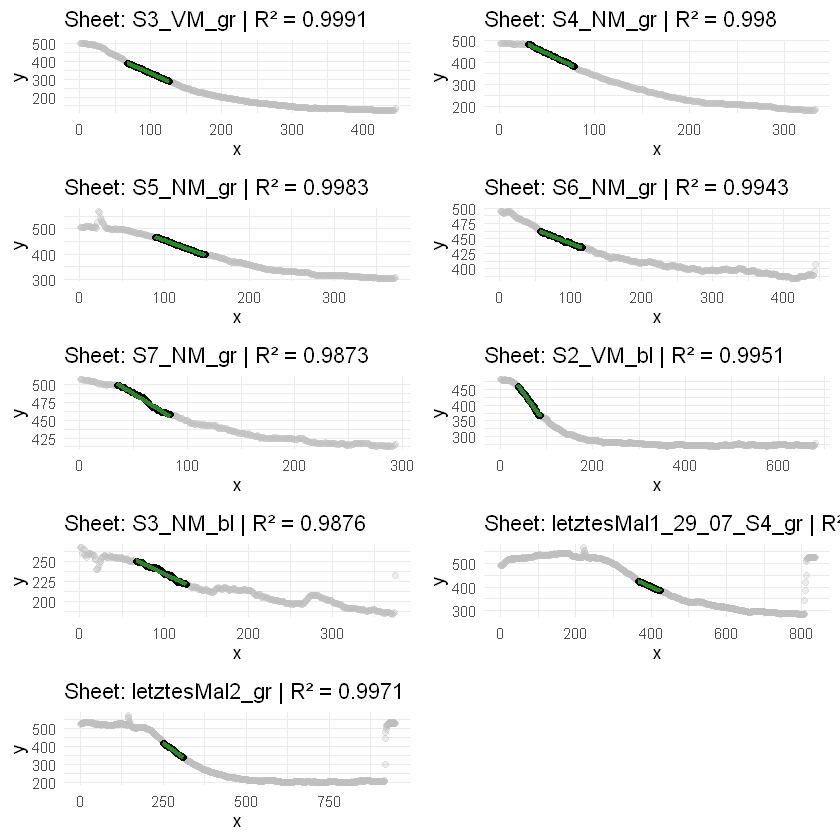

In [8]:
#  einzeln:
#for (p in plots_list) {
#  print(p)
#}

# as a grid:
do.call(grid.arrange, c(plots_list, ncol = 2))


### Step Size Consideration for Linear Fit Detection

To identify the most linear section of each CO₂ concentration curve, a sliding window approach was applied with a fixed step size of `5`. This means the algorithm evaluates overlapping segments by shifting the window 5 data points at a time across the time series.

This step size was chosen as a compromise between analytical resolution and computational efficiency:

- A smaller step size (e.g., `1` or `2`) would result in higher precision but increase computation time, which is unnecessary given the resolution of the dataset.
- A larger step size (e.g., `10` or `20`) would reduce runtime but may skip over narrow linear segments, potentially leading to less accurate segment selection.

Using a step size of `5` ensures that the search process is sensitive enough to detect well-fitting linear regions, while still being computationally efficient. So in the end, keeping the step size at 5 is a good balance between performance and accuracy, and it works well for this type of flux calculation.

